In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

# Get to know the slide

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [18]:
# #slide_nums = ['001', '002', '005', '012', '016', '019']
# slide_nums = ['081', '084','091', '094', '096', '101']
# slide_paths = []
# tumor_mask_paths = []

# for slide_num in slide_nums:
#   slide_paths.append('tumor_' + slide_num + '.tif')
#   tumor_mask_paths.append('tumor_' + slide_num + '_mask.tif')

In [19]:
# slide = open_slide(slide_paths[1]) #change
# print ("Read WSI from %s with width: %d, height: %d" % (slide, 
#                                                         slide.level_dimensions[0][0], 
#                                                         slide.level_dimensions[0][1])) 
# tumor_mask = open_slide(tumor_mask_paths[1]) #change 
# print ("Read tumor mask from %s" % (tumor_mask))

# print("Slide includes %d levels", len(slide.level_dimensions))
# for i in range(len(tumor_mask.level_dimensions)):
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              slide.level_dimensions[i], 
#                                                              slide.level_downsamples[i]))
#     assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
#     assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# # Verify downsampling works as expected
# width, height = slide.level_dimensions[7]
# assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
# assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from OpenSlide('tumor_084.tif') with width: 65536, height: 86016
Read tumor mask from OpenSlide('tumor_084_mask.tif')
Slide includes %d levels 9
Level 0, dimensions: (65536, 86016) downsample factor 1
Level 1, dimensions: (32768, 43008) downsample factor 2
Level 2, dimensions: (16384, 21504) downsample factor 4
Level 3, dimensions: (8192, 10752) downsample factor 8
Level 4, dimensions: (4096, 5376) downsample factor 16
Level 5, dimensions: (2048, 2688) downsample factor 32
Level 6, dimensions: (1024, 1344) downsample factor 64
Level 7, dimensions: (512, 672) downsample factor 128


In [20]:
slide

OpenSlide('tumor_084.tif')

In [3]:

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Find non-tissue areas by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

# Preprocess data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [5]:
# get all non-tissue windows test version 
def get_windows(slide_paths, tumor_mask_paths, level, stride = 150, window_len=299, threshold = 0.5):
    
  slide_windows = []
  contains_cancer = []

  for slide_path, tumor_mask_path in zip(slide_paths, tumor_mask_paths):
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)

    window_width = slide.level_dimensions[level][0] - window_len + 1 
    window_height = slide.level_dimensions[level][1] - window_len + 1
    downsample_factor = slide.level_downsamples[level]
    
    # sliding window
    for w in range(0, window_width, stride):
      for h in range(0, window_height, stride):
        curr_coord = (int(w*downsample_factor), int(h*downsample_factor))

        curr_slide = read_slide(slide,
                                 x=curr_coord[0],
                                 y=curr_coord[1],
                                 level=level,
                                 width=window_len,
                                 height=window_len)
        
        curr_tumor_mask = read_slide(tumor_mask,
                                      x=curr_coord[0],
                                      y=curr_coord[1],
                                      level=level,
                                      width=window_len,
                                      height=window_len)
        
        # calculate the percentage of tissue
        tissue_pixels = find_tissue_pixels(curr_slide)
        #print(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(curr_slide.shape[0] * curr_slide.shape[0] ) 
        #print("curr_slide shape", curr_slide.shape[0])) 
        #print("curr_slide shape", curr_slide.shape[0])

        if percent_tissue >= 0.2 and np.mean(curr_slide) > 0.2:
          slide_windows.append(curr_slide)
          if np.sum(curr_tumor_mask[:,:,0]) / (window_len * window_len)  >= threshold:
            contains_cancer.append(1)
          else:
            contains_cancer.append(0)

  return slide_windows, contains_cancer

In [6]:
def display_windows(images, row, col, x, y):
  fig = plt.figure(figsize=(x,y))
  shuffle = np.arange(len(images))
  np.random.shuffle(shuffle)
  for i in range(row):
    for j in range(col):
      idx = i*row+j
      ax = fig.add_subplot(col, row, idx+1)
      plt.imshow(images[shuffle[idx]])
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)

In [7]:
!ls ./content/slides_level1/slides_pos | wc -l

1732


## Zoom level 0

In [8]:
#slide_nums = ['001', '002', '005', '012', '016', '019']
# slide_nums = ['081', '084','091', '094', '096', '101']
slide_nums = ['094'] #TODO: CHECK
slide_paths = []
tumor_mask_paths = []

for slide_num in slide_nums:
  slide_paths.append('tumor_' + slide_num + '.tif')
  tumor_mask_paths.append('tumor_' + slide_num + '_mask.tif')

In [ ]:
slide_windows_z0, contains_cancer_z0 = get_windows(slide_paths, tumor_mask_paths, 1)  #change the level here , currently lebel 1 

# Percentage of windows with tumor
print("{:.1f}% windows with cancer ({:d}/{:d}) ".format(sum(contains_cancer_z0)/len(contains_cancer_z0)*100, sum(contains_cancer_z0), len(contains_cancer_z0)))

In [ ]:
windows_w_tumor_z0 = [slide_windows_z0[i] for i in range(len(contains_cancer_z0)) if contains_cancer_z0[i]==1]
windows_wo_tumor_z0 = [slide_windows_z0[i] for i in range(len(contains_cancer_z0)) if contains_cancer_z0[i]==0]

In [ ]:
display_windows(windows_w_tumor_z0, 8, 8, 10, 10)

In [ ]:
display_windows(windows_wo_tumor_z0, 8, 8, 10, 10)

### Shuffle and balance data

In [ ]:
# shuffle and balance dataset
shuffle_wo_tumor_z0 = np.arange(len(windows_wo_tumor_z0))
np.random.shuffle(shuffle_wo_tumor_z0)

ds_w_tumor_z0 = windows_w_tumor_z0
ds_wo_tumor_z0 = [windows_wo_tumor_z0[shuffle_wo_tumor_z0[i]] for i in shuffle_wo_tumor_z0[:len(windows_w_tumor_z0)]]

In [ ]:
display_windows(ds_w_tumor_z0, 8, 8, 10, 10)

In [ ]:
display_windows(ds_wo_tumor_z0, 8, 8, 10, 10)

## Save windows to disk as images


In [ ]:
# create directory to store windows
colab_root = "./content" 
if not os.path.exists(colab_root):
    os.mkdir(colab_root)

slides_level0_dir = os.path.join(colab_root,'slides_' + 'level1')#level1 here 

if not os.path.exists(slides_level0_dir):
    os.mkdir(slides_level0_dir)

# slides_level5_dir = os.path.join(colab_root,'slides_' + 'level5')

# if not os.path.exists(slides_level5_dir):
#     os.mkdir(slides_level5_dir)

In [ ]:
slides_z0_pos_dir = os.path.join(slides_level0_dir, "slides_pos")
slides_z0_neg_dir = os.path.join(slides_level0_dir, "slides_pos")

if not os.path.exists(slides_z0_pos_dir):
    os.mkdir(slides_z0_pos_dir)

if not os.path.exists(slides_z0_neg_dir):
    os.mkdir(slides_z0_neg_dir)

In [ ]:
slide_nums[0]

In [ ]:
# save images to disk (level 2)

for i, window in enumerate(ds_w_tumor_z0):
  img = Image.fromarray(window, 'RGB')
  img_name = 'window_' + str(i) + "_" + slide_nums[0] + '_pos.jpg'
  file_path = os.path.join(slides_z0_pos_dir, img_name)
  # img.save(img_name)
  np.save(open(file_path, 'wb'), img)

for i, window in enumerate(ds_wo_tumor_z0):
  img = Image.fromarray(window, 'RGB')
  img_name = 'window_' + str(i) + "_" + slide_nums[0] + '_neg.jpg'
  file_path = os.path.join(slides_z0_neg_dir, img_name)
  # img.save(img_name)
  np.save(open(file_path, 'wb'), img)

## Load image from disk

### Zoom level 0

In [ ]:
# load level 0 data
pos_images_z0 = []
for i, window in enumerate(ds_w_tumor_z0):
  img_name = 'window_' + str(i) + '_pos.jpg'
  file_path = os.path.join(slides_z0_pos_dir, img_name)
  image = np.load(file_path)
  pos_images_z0.append(image)

neg_images_z0 = []
for i, window in enumerate(ds_wo_tumor_z0):
  img_name = 'window_' + str(i) + '_neg.jpg'
  file_path = os.path.join(slides_z0_neg_dir, img_name)
  image = np.load(file_path)
  neg_images_z0.append(image)

NameError: name 'ds_windows_91' is not defined

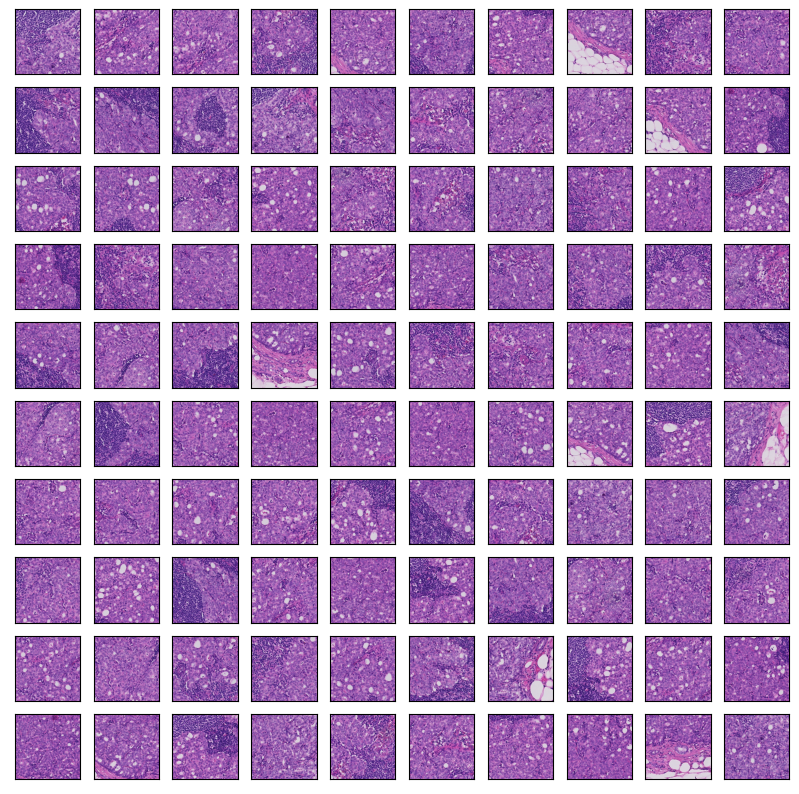

In [ ]:
display_windows(pos_images_z0, 10, 10, 10, 10)

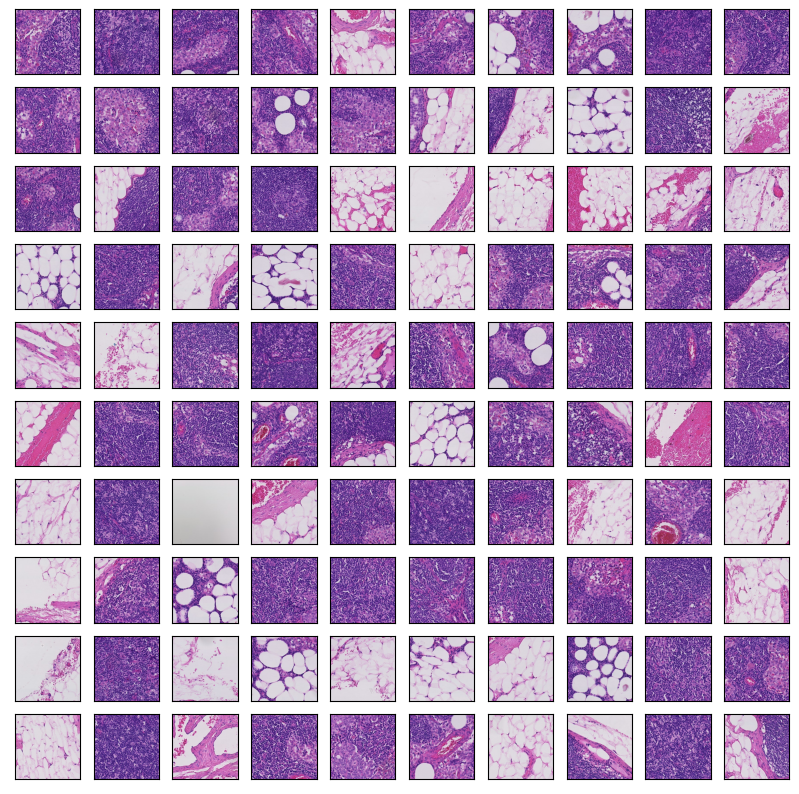

In [ ]:
display_windows(neg_images, 10, 10, 10, 10)

### Zoom level 5

In [ ]:
# load level 5 data
pos_images_z5 = []
for i, window in enumerate(ds_w_tumor_z5):
  img_name = 'window_' + str(i) + '_pos.jpg'
  file_path = os.path.join(slides_z5_pos_dir, img_name)
  image = np.load(file_path)
  pos_images_z5.append(image)

neg_images_z5 = []
for i, window in enumerate(ds_wo_tumor_z5):
  img_name = 'window_' + str(i) + '_neg.jpg'
  file_path = os.path.join(slides_z5_neg_dir, img_name)
  image = np.load(file_path)
  neg_images_z5.append(image)

In [ ]:
display_windows(pos_images_z5, 10, 10, 10, 10)

In [ ]:
display_windows(neg_images_z5, 10, 10, 10, 10)

# Create dataset for traininig, validation and testing

## Zoom level 0

In [ ]:
# shufflle data
assert len(pos_images_z0)==len(neg_images_z0)

images_z0 = np.concatenate((pos_images_z0 + neg_images_z0), axis=0)
labels_z0 = np.concatenate(np.ones(len(pos_images_z0), np.zeros(len(neg_images_z0))))

shuffle_z0 = np.arange(len(labels_z0))
np.random.shuffle(shuffle_z0)

ds_images_z0 = [images_z0[i] for i in shuffle_z0]
ds_labels_z0 = [labels_z0[i] for i in shuffle_z0]

In [ ]:
# train test split 80:20
train_window_z0 = np.array(ds_images_z0[:len(ds_labels_z0)//10*8])
train_label_z0 = np.array(ds_labels_z0[:len(ds_labels_z0)//10*8])

test_window_z0 = np.array(ds_images_z0[len(ds_labels_z0)//10*8:])
test_label_z0 = np.array(ds_labels_z0[len(ds_labels_z0)//10*8:])

In [ ]:
from sklearn.model_selection import train_test_split
X_train_z0, X_test_z0, y_train_z0, y_test_z0 = train_test_split(train_window_z0, train_label_z0, test_size=0.2)

## Zoom level 5

In [ ]:
# shufflle data
assert len(pos_images_z5)==len(neg_images_z5)

images_z5 = np.concatenate((pos_images_z5 + neg_images_z5), axis=0)
labels_z5 = np.concatenate(np.ones(len(pos_images_z5), np.zeros(len(neg_images_z5))))

shuffle_z5 = np.arange(len(labels_z5))
np.random.shuffle(shuffle_z5)

ds_images_z5 = [images_z5[i] for i in shuffle_z5]
ds_labels_z5 = [labels_z5[i] for i in shuffle_z5]

In [ ]:
# train test split 80:20
train_window_z5 = np.array(ds_images_z5[:len(ds_labels_z5)//10*8])
train_label_z5 = np.array(ds_labels_z5[:len(ds_labels_z5)//10*8])

test_window_z5 = np.array(ds_images_z5[len(ds_labels_z5)//10*8:])
test_label_z5 = np.array(ds_labels_z5[len(ds_labels_z5)//10*8:])

In [ ]:
from sklearn.model_selection import train_test_split
X_train_z5, X_test_z5, y_train_z5, y_test_z5 = train_test_split(train_window_z5, train_label_z5, test_size=0.2)